In [29]:
from keras.applications import VGG16
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from keras.optimizers import Adam


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [16]:
nTrain = x_train.shape[0]
nVal = y_test.shape[0]
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32
 
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
val_features = np.zeros(shape=(nVal, 7, 7, 512))
train_labels = np.zeros(shape=10)

In [5]:
from  skimage import transform

new_shape = (48,48,3)
x_train = np.asarray([transform.resize(image, new_shape) for image in x_train]) 
x_test  = np.asarray([transform.resize(image, new_shape) for image in x_test ])

/home/dex/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [6]:
type(x_train)

numpy.ndarray

In [7]:
train_generator = datagen.flow(
    x_train, 
    batch_size=batch_size, 
    shuffle=True)
i = 0
for inputs_batch  in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    
    i += 1 
    if i * batch_size >= nTrain:
        break

In [8]:
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512)) 

In [9]:
test_generator = datagen.flow(
    x_test, 
    batch_size = batch_size, 
    shuffle=True)

i = 0
for inputs_batch  in test_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    val_features[i * batch_size : (i + 1) * batch_size] = features_batch
    
    i += 1 
    if i * batch_size >= nVal:
        break
val_features = np.reshape(val_features, (nVal, 7 * 7 * 512))

In [30]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

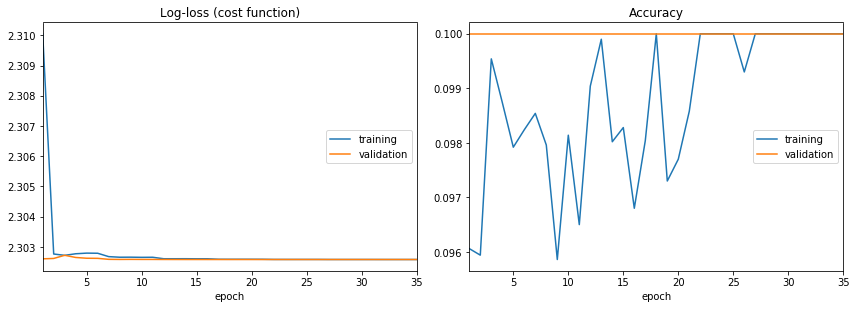

In [31]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [lr_reducer, PlotLossesKeras()] 
model.compile(optimizer = Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])
 
history = model.fit(train_features, y_train,
                    epochs = 35,
                    batch_size = batch_size,verbose=1, 
                    validation_data=(val_features,y_test), callbacks=callbacks)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(train_features, verbose=2)
Y_pred

array([[0.10001848, 0.1000118 , 0.09997834, ..., 0.10001742, 0.0999981 ,
        0.09997267],
       [0.10001848, 0.1000118 , 0.09997834, ..., 0.10001742, 0.0999981 ,
        0.09997267],
       [0.10001848, 0.1000118 , 0.09997834, ..., 0.10001742, 0.0999981 ,
        0.09997267],
       ...,
       [0.10001848, 0.1000118 , 0.09997834, ..., 0.10001742, 0.0999981 ,
        0.09997267],
       [0.10001848, 0.1000118 , 0.09997834, ..., 0.10001742, 0.0999981 ,
        0.09997267],
       [0.10001848, 0.1000118 , 0.09997834, ..., 0.10001742, 0.0999981 ,
        0.09997267]], dtype=float32)